In [1]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, BatchNormalization, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
from time import time

D:\anaconda\envs\gpuenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
ds = tfds.load("fashion_mnist", split="train")
dataiterator = ds.as_numpy_iterator()

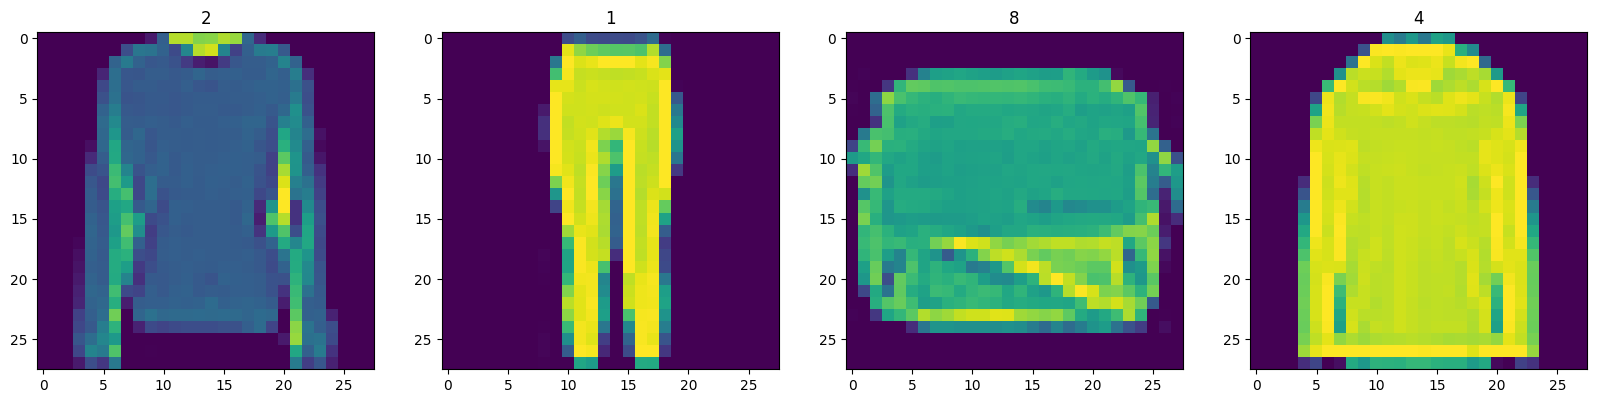

In [4]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image'])) 
    ax[idx].title.set_text(sample['label'])

In [5]:
def scale_images(x):
    image = tf.cast(x['image'], tf.float32) / 255.0
    return image

ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [6]:
def generator_model():
    
    model = Sequential()
    
    model.add(Dense(7*7*128, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_shape=(128,)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Reshape((7,7,128)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1,kernel_size=3,padding="same", activation="tanh"))

    return model

In [7]:
generator = generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 256)       295168    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 256)      1

In [8]:
def discriminator_model(): 
    
    model = Sequential()
    
    model.add(Conv2D(32, 5, input_shape = (28,28,1) , activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, 5, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, 5, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, 5, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [9]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 256)      

In [10]:
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate = 0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [11]:
class GAN(Model):
    def __init__(self,generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.d_loss = d_loss 
        self.g_loss = g_loss
        
    def train_step(self, batch):
        
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,128,1)), training=False)
        
        # Train the discriminator
        
        with tf.GradientTape() as d_tape:
            
             # Pass real and fake images into discriminator
                d_pred_real = self.discriminator(real_images, training=True)
                d_pred_fake = self.discriminator(fake_images, training=True)
    
                d_pred = tf.concat([d_pred_real, d_pred_fake], axis=0)
        
             # Create labels to train
                d_labels = tf.concat([tf.zeros_like(d_pred_real), tf.ones_like(d_pred_fake)], axis=0)
            
            # Adding noise to training set
                real_noise = 0.15*tf.random.uniform(tf.shape(d_pred_real))
                fake_noise = -0.15*tf.random.uniform(tf.shape(d_pred_fake))
                
                d_labels += tf.concat([real_noise, fake_noise], axis=0)
                
                # loss calculation
                calc_d_loss = self.d_loss(d_labels, d_pred)
                
        # Discriminator backprop
        d_gradient = d_tape.gradient(calc_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        
        # Train the generator
        
        with tf.GradientTape() as g_tape:
            gen_imgs = self.generator(tf.random.normal((128,128,1)), training=True)
            
            pred_labels = self.discriminator(gen_imgs, training=False)
            
            calc_g_loss = self.g_loss(tf.zeros_like(pred_labels), pred_labels)
            
        # Generator backprop
        g_gradient = g_tape.gradient(calc_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(g_gradient, self.generator.trainable_variables))
            
        return {"d_loss": calc_d_loss, "g_loss":calc_g_loss}

In [12]:
gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [13]:
# Trained locally for 60 epochs; increasing epoch value will result in more accurate image generation.

start = time()
hist = gan.fit(ds, epochs=60, verbose=2)
print(time()-start)

Epoch 1/60
469/469 - 46s - d_loss: 0.6907 - g_loss: 0.6867 - 46s/epoch - 98ms/step
Epoch 2/60
469/469 - 41s - d_loss: 0.6990 - g_loss: 0.6566 - 41s/epoch - 88ms/step
Epoch 3/60
469/469 - 41s - d_loss: 0.6938 - g_loss: 0.6730 - 41s/epoch - 88ms/step
Epoch 4/60
469/469 - 41s - d_loss: 0.6966 - g_loss: 0.6858 - 41s/epoch - 88ms/step
Epoch 5/60
469/469 - 41s - d_loss: 0.6496 - g_loss: 0.7682 - 41s/epoch - 88ms/step
Epoch 6/60
469/469 - 42s - d_loss: 0.6943 - g_loss: 0.6493 - 42s/epoch - 88ms/step
Epoch 7/60
469/469 - 42s - d_loss: 0.6939 - g_loss: 0.6577 - 42s/epoch - 89ms/step
Epoch 8/60
469/469 - 43s - d_loss: 0.6875 - g_loss: 0.6454 - 43s/epoch - 92ms/step
Epoch 9/60
469/469 - 41s - d_loss: 0.6511 - g_loss: 0.9047 - 41s/epoch - 88ms/step
Epoch 10/60
469/469 - 41s - d_loss: 0.5008 - g_loss: 2.1264 - 41s/epoch - 88ms/step
Epoch 11/60
469/469 - 41s - d_loss: 0.4403 - g_loss: 2.0304 - 41s/epoch - 88ms/step
Epoch 12/60
469/469 - 41s - d_loss: 0.5467 - g_loss: 1.0870 - 41s/epoch - 88ms/step
E

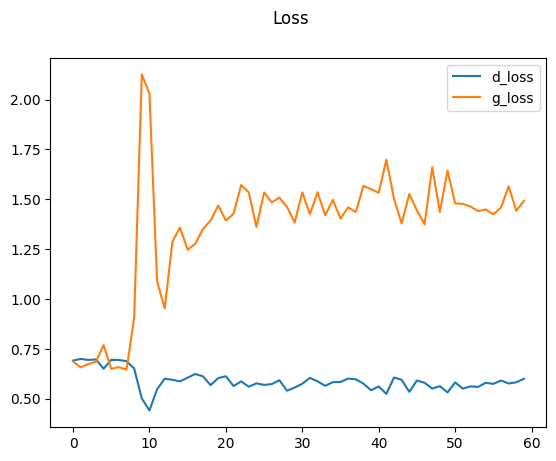

In [14]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 119ms/step


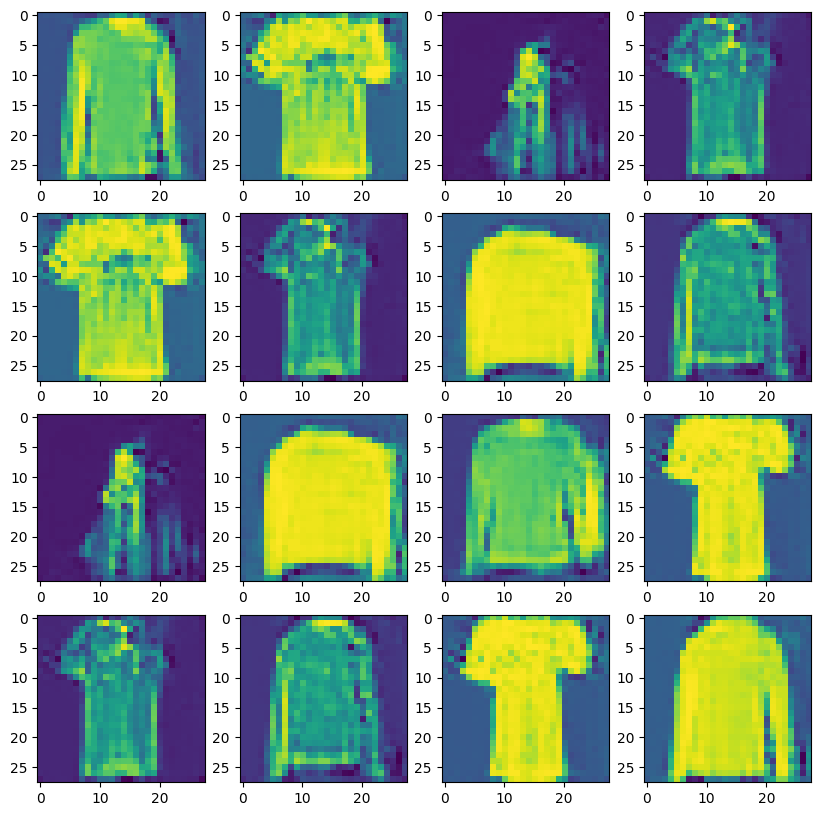

In [15]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])